<a href="https://www.kaggle.com/code/javihm77/random-forest-lb-catboost-gameplay-chapu?scriptVersionId=126195513" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Libraries

In [1]:
# !pip install polars

# Reading training file

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import polars as pl
import gc
import os
from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from vowpalwabbit.sklearn_vw import VWClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# settings
warnings.filterwarnings("ignore")

/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv
/kaggle/input/predict-student-performance-from-game-play/train_labels.csv
/kaggle/input/predict-student-performance-from-game-play/train.csv
/kaggle/input/predict-student-performance-from-game-play/test.csv
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/__init__.py


In [3]:
dtypes = {"session_id": pl.Int64,
          "elapsed_time": pl.Int64,
          "event_name": pl.Categorical,
          "name": pl.Categorical,
          "level": pl.Int8,
          "page": pl.Float32,
          "room_coor_x": pl.Float32,
          "room_coor_y": pl.Float32,
          "screen_coor_x": pl.Float32,
          "screen_coor_y": pl.Float32,
          "hover_duration": pl.Float32,
          "text": pl.Categorical,
          "fqid": pl.Categorical,
          "room_fqid": pl.Categorical,
          "text_fqid": pl.Categorical,
          "fullscreen": pl.Int8,
          "hq": pl.Int8,
          "music": pl.Int8,
          "level_group": pl.Categorical
          }

In [4]:
columns = [

    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) 
         .fill_null(0)
         .clip(0, 1e9)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) 
         .fill_null(0)
         .abs()
         .over(["session_id", "level_group"])
        .alias("location_x_diff") 
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) 
         .fill_null(0)
         .abs()
         .over(["session_id", "level_group"])
        .alias("location_y_diff") 
    )
]

In [5]:
#pl.StringCache()
pl.toggle_string_cache(True)
#pub fn toggle_string_cache(toggle: bool)

## Reading from Kaggle Environment

In [6]:
%%time
files_status = True

try:    
    #train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtype=dtypes)
    train = (pl.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',dtypes=dtypes)
                .drop(["fullscreen", "hq", "music"])
                .with_columns(columns)
              )
    targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
    #test = pd.read_csv("'/kaggle/input/predict-student-performance-from-game-play/test.csv'")
except OSError as e:
    print("files not found in Kaggle environment: ",e.errno)
    files_status = False

CPU times: user 41.5 s, sys: 15.1 s, total: 56.7 s
Wall time: 53 s


## Reading from local environment (files folder)

In [7]:
%%time
#If environment is not kaggle notebook, read them from a folder 

try:
    if files_status == False:
        train = (pl.read_csv("predict-student-performance-from-game-play/train.csv", dtypes=dtypes)
                    .drop(["fullscreen", "hq", "music"])
                    .with_columns(columns)
                )
        targets = pd.read_csv('predict-student-performance-from-game-play/train_labels.csv')
except OSError as e:
    print("Files not found")

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.34 µs


In [8]:
print(f"Memory usage of dataframe is {round(train.estimated_size('mb'), 2)} MB")

Memory usage of dataframe is 2360.58 MB


# Reducing training file

In [9]:
def reduce_memory_usage_pl(df, name):
    """ Reduce memory usage by polars dataframe {df} with name {name} by changing its data types.
        Original pandas version of this function: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 """
    print(f"Memory usage of dataframe {name} is {round(df.estimated_size('mb'), 2)} MB")
    Numeric_Int_types = [pl.Int8,pl.Int16,pl.Int32,pl.Int64]
    Numeric_Float_types = [pl.Float32,pl.Float64]    
    for col in df.columns:
        col_type = df[col].dtype
        c_min = df[col].min()
        c_max = df[col].max()
        if col_type in Numeric_Int_types:
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(df[col].cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(df[col].cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(df[col].cast(pl.Int32))
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df = df.with_columns(df[col].cast(pl.Int64))
        elif col_type in Numeric_Float_types:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(df[col].cast(pl.Float32))
            else:
                pass
        elif col_type == pl.Utf8:
            df = df.with_columns(df[col].cast(pl.Categorical))
        else:
            pass
    
    print(f"Memory usage of dataframe {name} became {round(df.estimated_size('mb'), 2)} MB")
    return df

In [10]:
# Reducing polar
train = reduce_memory_usage_pl(train, "train_subset")

Memory usage of dataframe train_subset is 2360.58 MB
Memory usage of dataframe train_subset became 2009.48 MB


In [11]:
print(train.columns)
print(train.shape)
print(len(train))
print(type(train))

['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level', 'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid', 'level_group', 'elapsed_time_diff', 'location_x_diff', 'location_y_diff']
(26296946, 20)
26296946
<class 'polars.dataframe.frame.DataFrame'>


In [12]:
train.tail(4)

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group,elapsed_time_diff,location_x_diff,location_y_diff
i64,i16,i32,cat,cat,i8,f32,f32,f32,f32,f32,f32,cat,cat,cat,cat,cat,i32,f32,f32
22100221145014656,1601,5485166,"""navigate_click…","""undefined""",22,null,332.696075,141.493179,545.0,221.0,null,null,"""chap4_finale_c…","""tunic.capitol_…",null,"""13-22""",1935,62.0,52.0
22100221145014656,1602,5485917,"""navigate_click…","""undefined""",22,null,369.912872,140.569199,611.0,217.0,null,null,null,"""tunic.capitol_…",null,"""13-22""",751,66.0,4.0
22100221145014656,1603,5486753,"""navigate_click…","""undefined""",22,null,252.299652,123.805893,526.0,232.0,null,null,"""chap4_finale_c…","""tunic.capitol_…",null,"""13-22""",836,85.0,15.0
22100221145014656,1604,5487952,"""checkpoint""","""basic""",22,null,null,null,null,null,null,null,"""chap4_finale_c…","""tunic.capitol_…",null,"""13-22""",1199,0.0,0.0


# Feature Engineering for training file

In [13]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

# from https://www.kaggle.com/code/leehomhuang/catboost-baseline-with-lots-features-inference :
fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

In [14]:
def feature_engineer_pl(x, grp, use_extra, feature_suffix):
        
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),
      
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],
        [pl.col(c).quantile(0.1, "nearest").alias(f"{c}_quantile1_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.2, "nearest").alias(f"{c}_quantile2_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.4, "nearest").alias(f"{c}_quantile4_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.6, "nearest").alias(f"{c}_quantile6_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.8, "nearest").alias(f"{c}_quantile8_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.9, "nearest").alias(f"{c}_quantile9_{feature_suffix}") for c in NUMS],
        
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        
        *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}")for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(0.1, "nearest").alias(f"{c}_ET_quantile1_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(0.2, "nearest").alias(f"{c}_ET_quantile2_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(0.4, "nearest").alias(f"{c}_ET_quantile4_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(0.6, "nearest").alias(f"{c}_ET_quantile6_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(0.8, "nearest").alias(f"{c}_ET_quantile8_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(0.9, "nearest").alias(f"{c}_ET_quantile9_{feature_suffix}") for c in event_name_feature],      
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in event_name_feature],
     
        *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}")for c in name_feature],   
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in name_feature],  
        
        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}")for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in room_lists],
                
        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}")for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in fqid_lists],
       
        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in text_lists],
         
        *[pl.col("location_x_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_x{feature_suffix}") for c in event_name_feature],
        *[pl.col("location_x_diff").filter(pl.col("event_name")==c).std().alias(f"{c}_ET_std_x{feature_suffix}") for c in event_name_feature],
        *[pl.col("location_x_diff").filter(pl.col("event_name")==c).max().alias(f"{c}_ET_max_x{feature_suffix}") for c in event_name_feature],
        *[pl.col("location_x_diff").filter(pl.col("event_name")==c).min().alias(f"{c}_ET_min_x{feature_suffix}") for c in event_name_feature],
        ]
    
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
  
    if use_extra:
        if grp=='5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp=='13-22':
            aggs = [
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')
        
    return df.to_pandas()

## Filling Null Values

In [15]:
#Quantity of nulls per column
def nulls_per_column(df_polar):
    len_df_polar = len(df_polar)
    for col in df_polar.get_columns():
        per_nulls = round((col.is_null().sum() / len_df_polar) * 100,2)
        print(f'{col.name} - {per_nulls}%')

In [16]:
def clean_missing_values(df_polar):
    
    
    filled_polar = df_polar.select(
        pl.col('session_id'),
        pl.col('index'),
        pl.col('elapsed_time'),
        pl.col('event_name'),
        pl.col('name'),
        pl.col('level'),
        pl.col('page').fill_null(0),
        pl.col('room_coor_x').fill_null(strategy="backward"),
        pl.col('room_coor_x').fill_null(strategy='backward'),
        pl.col('room_coor_y').fill_null(strategy='backward'),
        pl.col('screen_coor_x').fill_null(strategy='backward'),
        pl.col('screen_coor_y').fill_null(strategy='backward'),
        pl.col('hover_duration').fill_null(0),
        pl.col('text').fill_null('No Text'),
        pl.col('fqid').fill_null('No fqid'),
        pl.col('room_fqid'),
        pl.col('text_fqid').fill_null('No text_fqid'),
        pl.col('level_group'),
        pl.col('elapsed_time_diff'),
        pl.col('location_x_diff'),
        pl.col('location_y_diff')
    )
    
    filled_polar.tail(5)
    
    return filled_polar

In [17]:
#Nulls of train dataset
nulls_per_column(train)

session_id - 0.0%
index - 0.0%
elapsed_time - 0.0%
event_name - 0.0%
name - 0.0%
level - 0.0%
page - 97.85%
room_coor_x - 7.88%
room_coor_y - 7.88%
screen_coor_x - 7.88%
screen_coor_y - 7.88%
hover_duration - 92.39%
text - 63.43%
fqid - 31.47%
room_fqid - 0.0%
text_fqid - 63.43%
level_group - 0.0%
elapsed_time_diff - 0.0%
location_x_diff - 0.0%
location_y_diff - 0.0%


In [18]:
%%time
df1 = train.filter(pl.col("level_group")=='0-4')
df2 = train.filter(pl.col("level_group")=='5-12')
df3 = train.filter(pl.col("level_group")=='13-22')
print("df1: ",df1.shape," df2: ",df2.shape," df3: ",df3.shape)

df1:  (3981005, 20)  df2:  (8844238, 20)  df3:  (13471703, 20)
CPU times: user 1.11 s, sys: 1.11 s, total: 2.22 s
Wall time: 1.17 s


In [19]:
#Delete train to liberate memory
del train
gc.collect()

135

In [20]:
df1 = df1.fill_null(0)
df1 = df1.fill_nan(0)
df2 = df2.fill_null(0)
df2 = df2.fill_nan(0)
df3 = df3.fill_null(0)
df3 = df3.fill_nan(0)

In [21]:
nulls_per_column(df1)

session_id - 0.0%
index - 0.0%
elapsed_time - 0.0%
event_name - 0.0%
name - 0.0%
level - 0.0%
page - 0.0%
room_coor_x - 0.0%
room_coor_y - 0.0%
screen_coor_x - 0.0%
screen_coor_y - 0.0%
hover_duration - 0.0%
text - 62.41%
fqid - 38.12%
room_fqid - 0.0%
text_fqid - 62.41%
level_group - 0.0%
elapsed_time_diff - 0.0%
location_x_diff - 0.0%
location_y_diff - 0.0%


In [22]:
df1.tail(5)

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group,elapsed_time_diff,location_x_diff,location_y_diff
i64,i16,i32,cat,cat,i8,f32,f32,f32,f32,f32,f32,cat,cat,cat,cat,cat,i32,f32,f32
22100221145014656,206,352635,"""navigate_click…","""undefined""",4,0.0,-914.204224,-50.0,26.0,380.0,0.0,null,"""toentry""","""tunic.kohlcent…",null,"""0-4""",332,2.0,1.0
22100221145014656,207,353336,"""map_hover""","""basic""",4,0.0,0.0,0.0,0.0,0.0,84.0,null,"""tunic.kohlcent…","""tunic.kohlcent…",null,"""0-4""",701,0.0,0.0
22100221145014656,208,354020,"""map_click""","""undefined""",4,0.0,-549.217712,-2.0,449.0,332.0,0.0,null,"""tunic.capitol_…","""tunic.kohlcent…",null,"""0-4""",684,0.0,0.0
22100221145014656,209,356238,"""navigate_click…","""undefined""",4,0.0,313.584259,107.913147,463.0,226.0,0.0,null,"""chap1_finale""","""tunic.capitol_…",null,"""0-4""",2218,14.0,106.0
22100221145014656,210,435055,"""checkpoint""","""basic""",4,0.0,0.0,0.0,0.0,0.0,0.0,null,"""chap1_finale_c…","""tunic.capitol_…",null,"""0-4""",78817,0.0,0.0


In [23]:
%%time
df1 = feature_engineer_pl(df1, grp='0-4', use_extra=True, feature_suffix='')
print('df1 done, shape: ',df1.shape)

df1 done, shape:  (23562, 1898)
CPU times: user 15 s, sys: 586 ms, total: 15.6 s
Wall time: 8.19 s


In [24]:
%%time
df2 = feature_engineer_pl(df2, grp='5-12', use_extra=True, feature_suffix='')
print('df2 done, shape: ',df2.shape)

df2 done, shape:  (23562, 1904)
CPU times: user 35 s, sys: 975 ms, total: 36 s
Wall time: 18.9 s


In [25]:
%%time
df3 = feature_engineer_pl(df3, grp='13-22', use_extra=True, feature_suffix='')
print('df3 done, shape: ',df3.shape)

df3 done, shape:  (23562, 1902)
CPU times: user 55 s, sys: 1.07 s, total: 56.1 s
Wall time: 28.9 s


In [26]:
df1.isna().sum().sort_values(ascending=False)

block_ET_min_                               23562
colorbook_ET_max_                           23562
journals_flag_ET_max_                       23562
journals.pic_1.next_ET_max_                 23562
logbook.page.bingo_ET_max_                  23562
                                            ...  
journals_flag.hub.topics_old_fqid_counts        0
outtolunch_fqid_counts                          0
report_fqid_counts                              0
chap1_finale_fqid_counts                        0
session_id                                      0
Length: 1898, dtype: int64

In [27]:
# some cleaning...
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df1)

drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)
print("Drop 1: ",len(drop1), len(drop2), len(drop3))

for col in df1.columns:
    if df1[col].nunique()==1:
        drop1.append(col)
print("*********df1 DONE*********")
for col in df2.columns:
    if df2[col].nunique()==1:
        drop2.append(col)
print("*********df2 DONE*********")
for col in df3.columns:
    if df3[col].nunique()==1:
        drop3.append(col)
print("*********df3 DONE*********")

Drop 1:  1078 824 715
*********df1 DONE*********
*********df2 DONE*********
*********df3 DONE*********


In [28]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 586 903 1052 features
We will train with 23562 users info


In [29]:
df1[FEATURES1] = df1[FEATURES1].fillna(0)
df2[FEATURES2] = df2[FEATURES2].fillna(0)
df3[FEATURES3] = df3[FEATURES3].fillna(0)

In [30]:
#listing columns with NaN values
df1[FEATURES1].columns[df1[FEATURES1].isna().any()].tolist()

[]

In [31]:
df2[FEATURES2].columns[df2[FEATURES2].isna().any()].tolist()

[]

In [32]:
df3[FEATURES3].columns[df3[FEATURES3].isna().any()].tolist()

[]

In [33]:
df1.head(10)

,session_number_,event_name_unique_,name_unique_,fqid_unique_,room_fqid_unique_,text_fqid_unique_,,page_quantile2_,room_coor_x_quantile2_,room_coor_y_quantile2_,...,person_click_ET_min_x,navigate_click_ET_min_x,observation_click_ET_min_x,notification_click_ET_min_x,object_click_ET_min_x,object_hover_ET_min_x,map_hover_ET_min_x,map_click_ET_min_x,checkpoint_ET_min_x,notebook_click_ET_min_x
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,165,10,3,30,7,17,b'\xf0\x80\xef\x9d\x17~\x00\x00',0.0,-358.832031,-167.307098,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20090312433251036,139,11,4,22,6,11,b'\xf0\x80\xef\x9d\x17~\x00\x00',0.0,-394.991394,-173.290939,...,0.0,0.0,21.0,37.0,0.0,0.0,0.0,0.0,0.0,22.0
20090312455206810,149,9,3,22,6,12,b'\xf0\x80\xef\x9d\x17~\x00\x00',0.0,-538.784363,-183.048019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20090313091715820,176,11,4,24,6,14,b'\xf0\x80\xef\x9d\x17~\x00\x00',0.0,-515.337463,-210.307907,...,0.0,0.0,218.0,0.0,0.0,0.0,0.0,0.0,0.0,119.0
20090313571836404,112,10,4,22,6,12,b'\xf0\x80\xef\x9d\x17~\x00\x00',0.0,-376.401917,-140.303604,...,0.0,0.0,0.0,77.0,0.0,0.0,0.0,0.0,0.0,41.0
20090314035813970,154,11,4,26,6,19,b'\xf0\x80\xef\x9d\x17~\x00\x00',0.0,-342.963806,-176.862640,...,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20090314121766812,165,11,4,26,7,15,b'\xf0\x80\xef\x9d\x17~\x00\x00',0.0,-217.520538,-159.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
20090314221187252,210,11,4,23,6,14,b'\xf0\x80\xef\x9d\x17~\x00\x00',0.0,-307.307678,-140.000000,...,0.0,0.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
20090314363702160,146,9,3,21,7,11,b'\xf0\x80\xef\x9d\x17~\x00\x00',0.0,-313.609833,-119.883316,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
df1.shape

(23562, 1897)

In [35]:
# splitting dataframe in a particular size
df1_split = df1.sample(frac=0.15,random_state=200)
df1.reset_index()
df1_split.shape

(3534, 1897)

In [36]:
df1_split.head(5)

,session_number_,event_name_unique_,name_unique_,fqid_unique_,room_fqid_unique_,text_fqid_unique_,,page_quantile2_,room_coor_x_quantile2_,room_coor_y_quantile2_,...,person_click_ET_min_x,navigate_click_ET_min_x,observation_click_ET_min_x,notification_click_ET_min_x,object_click_ET_min_x,object_hover_ET_min_x,map_hover_ET_min_x,map_click_ET_min_x,checkpoint_ET_min_x,notebook_click_ET_min_x
session_id,,,,,,,,,,,,,,,,,,,,,
21040108044106436,114,10,4,24,6,11,b'\xf0\x80\xef\x9d\x17~\x00\x00',0.0,-474.005402,-199.692261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,588.0
21000619545284540,128,10,4,22,6,10,b'\xf0\x80\xef\x9d\x17~\x00\x00',0.0,-321.037537,-241.077423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,275.0
22080511372705110,132,11,4,25,6,15,b'\xf0\x80\xef\x9d\x17~\x00\x00',0.0,-299.648102,-148.618774,...,0.0,0.0,176.0,1.0,0.0,0.0,0.0,0.0,0.0,765.0
22050111003865560,119,11,4,24,7,14,b'\xf0\x80\xef\x9d\x17~\x00\x00',0.0,-285.043396,-158.635696,...,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,760.0
21030513041475336,156,9,3,21,6,12,b'\xf0\x80\xef\x9d\x17~\x00\x00',0.0,-400.827362,-181.005508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# splitting dataframe in a particular size
df2_split = df2.sample(frac=0.15,random_state=200)
df2.reset_index()
df2_split.shape

(3534, 1903)

In [38]:
# splitting dataframe in a particular size
df3_split = df3.sample(frac=0.15,random_state=200)
df3.reset_index()
df3_split.shape

(3534, 1901)

## Cleaning Variables to free RAM Memory

In [39]:
all_variables = dir()
  
# Iterate over the whole list where dir( )
# is stored.
for name in all_variables:
    
    # Print the item if it doesn't start with '__'
    if not name.startswith('__'):
        myvalue = eval(name)
        #print(name, "is", type(myvalue), "and is equal to ", myvalue)
        print(name, "is", type(myvalue))

ALL_USERS is <class 'pandas.core.indexes.numeric.Int64Index'>
CATS is <class 'list'>
FEATURES1 is <class 'list'>
FEATURES2 is <class 'list'>
FEATURES3 is <class 'list'>
GridSearchCV is <class 'abc.ABCMeta'>
GroupKFold is <class 'abc.ABCMeta'>
In is <class 'list'>
KFold is <class 'abc.ABCMeta'>
NUMS is <class 'list'>
Out is <class 'dict'>
RandomForestClassifier is <class 'abc.ABCMeta'>
RandomizedSearchCV is <class 'abc.ABCMeta'>
VWClassifier is <class 'type'>
_ is <class 'list'>
_12 is <class 'polars.dataframe.frame.DataFrame'>
_19 is <class 'int'>
_22 is <class 'polars.dataframe.frame.DataFrame'>
_26 is <class 'pandas.core.series.Series'>
_30 is <class 'list'>
_31 is <class 'list'>
_32 is <class 'list'>
_33 is <class 'pandas.core.frame.DataFrame'>
_34 is <class 'tuple'>
_35 is <class 'tuple'>
_36 is <class 'pandas.core.frame.DataFrame'>
_37 is <class 'tuple'>
_38 is <class 'tuple'>
_dh is <class 'list'>
_i is <class 'str'>
_i1 is <class 'str'>
_i10 is <class 'str'>
_i11 is <class 'str'

In [40]:
#del clean_missing_values,col
#del null1,null2,null3,drop1,drop2,drop3,dtypes,event_name_feature,room_lists,text_lists
#del fqid_lists,name_feature,reduce_memory_usage_pl,


In [41]:
gc.collect()

168

## Group KFold

In [42]:
gkf = GroupKFold(n_splits=2)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}
print(oof.head(3))
print("Shape oof: ",oof.shape)

                    0    1    2    3    4    5    6    7    8    9    10   11  \
session_id                                                                      
20090312431273200  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
20090312433251036  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
20090312455206810  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                    12   13   14   15   16   17  
session_id                                       
20090312431273200  0.0  0.0  0.0  0.0  0.0  0.0  
20090312433251036  0.0  0.0  0.0  0.0  0.0  0.0  
20090312455206810  0.0  0.0  0.0  0.0  0.0  0.0  
Shape oof:  (23562, 18)


# Randomized Search CV

In [43]:
param_grid = {
    'n_estimators': [25,40,60,80,90,100],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3,6,9],
    'max_leaf_nodes': [3,6,9],
    'min_samples_split' : [2, 5],
    'bootstrap' : [True,False]
}

In [44]:
#Randomized Search CV
grid_search = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_grid, cv = 2, verbose=2, n_jobs = 3) 

In [45]:
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))

In [46]:
%%time

rf_best_params = []

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):
#for t in range(1,2):           
    if t<=3: 
        grp = '0-4'
        df = df1_split
        FEATURES = FEATURES1

    elif t<=13: 
        grp = '5-12'
        df = df2_split
        FEATURES = FEATURES2

    elif t<=22: 
        grp = '13-22'
        df = df3_split
        FEATURES = FEATURES3
            
    # TRAIN DATA
    train_x = df
    #train_x = train_x.loc[train_x.level_group == grp]
    train_users = train_x.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
             
    # TRAIN MODEL
    grid_search.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
    print(f'*** Grid Search Model: {grp}_{t}')
    print()
    #print(grid_search.best_estimator_)
    rf_best_params.append(grid_search.best_params_)
        
print()

Fitting 2 folds for each of 10 candidates, totalling 20 fits
*** Grid Search Model: 0-4_1

Fitting 2 folds for each of 10 candidates, totalling 20 fits
*** Grid Search Model: 0-4_2

Fitting 2 folds for each of 10 candidates, totalling 20 fits
*** Grid Search Model: 0-4_3

Fitting 2 folds for each of 10 candidates, totalling 20 fits
*** Grid Search Model: 5-12_4

Fitting 2 folds for each of 10 candidates, totalling 20 fits
*** Grid Search Model: 5-12_5

Fitting 2 folds for each of 10 candidates, totalling 20 fits
*** Grid Search Model: 5-12_6

Fitting 2 folds for each of 10 candidates, totalling 20 fits
*** Grid Search Model: 5-12_7

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, max_leaf_nodes=3, min_samples_split=5, n_estimators=25; total time=   0.3s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, max_leaf_nodes=3, min_samples_split=5, n_estimators=90; total time=   1.1s
[CV] END bootstrap=True, max_depth

In [47]:
for i in range(len(rf_best_params)):    
    print("Model: ",i+1," ",rf_best_params[i])

Model:  1   {'n_estimators': 25, 'min_samples_split': 2, 'max_leaf_nodes': 6, 'max_features': None, 'max_depth': 3, 'bootstrap': True}
Model:  2   {'n_estimators': 90, 'min_samples_split': 2, 'max_leaf_nodes': 3, 'max_features': 'log2', 'max_depth': 9, 'bootstrap': False}
Model:  3   {'n_estimators': 80, 'min_samples_split': 5, 'max_leaf_nodes': 9, 'max_features': 'sqrt', 'max_depth': 9, 'bootstrap': True}
Model:  4   {'n_estimators': 80, 'min_samples_split': 2, 'max_leaf_nodes': 6, 'max_features': None, 'max_depth': 9, 'bootstrap': True}
Model:  5   {'n_estimators': 90, 'min_samples_split': 2, 'max_leaf_nodes': 9, 'max_features': 'log2', 'max_depth': 6, 'bootstrap': False}
Model:  6   {'n_estimators': 90, 'min_samples_split': 2, 'max_leaf_nodes': 6, 'max_features': None, 'max_depth': 6, 'bootstrap': True}
Model:  7   {'n_estimators': 25, 'min_samples_split': 2, 'max_leaf_nodes': 3, 'max_features': 'sqrt', 'max_depth': 6, 'bootstrap': False}
Model:  8   {'n_estimators': 90, 'min_sample

In [48]:
del df1_split
del df2_split
del df3_split
gc.collect()

1041

# Train Random Forest

## Questions 1 to 3

In [49]:
%%time
warnings.filterwarnings("ignore")

# COMPUTE CV SCORE WITH 2 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df1[FEATURES1], groups=df1[FEATURES1].index)):
    
    print('-'*25)
    print('--- Fold',i+1)
    print('-'*25)
    print('Questions: ')

    for t in range(1,4):
    #for t in range(1,2):

        print(t,' - ',end='')
        bp = rf_best_params[t-1]

        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: 
            grp = '0-4'
            df = df1
            FEATURES = FEATURES1

        elif t<=13: 
            grp = '5-12'
            df = df2
            FEATURES = FEATURES2

        elif t<=22: 
            grp = '13-22'
            df = df3
            FEATURES = FEATURES3

        bp = rf_best_params[t-1]

        # TRAIN DATA
        train_x = df[FEATURES].iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df[FEATURES].iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]

        # TRAIN MODEL
        clf = RandomForestClassifier(n_estimators=bp['n_estimators'],max_depth=bp['max_depth'],min_samples_split=bp['min_samples_split'],
                                         max_features=bp['max_features'],max_leaf_nodes=bp['max_leaf_nodes'],bootstrap=bp['bootstrap']) 
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])

        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        print(f'Model Random Forest saved for question {t}')



-------------------------
--- Fold 1
-------------------------
Questions: 
1  - Model Random Forest saved for question 1
2  - Model Random Forest saved for question 2
3  - Model Random Forest saved for question 3
-------------------------
--- Fold 2
-------------------------
Questions: 
1  - Model Random Forest saved for question 1
2  - Model Random Forest saved for question 2
3  - Model Random Forest saved for question 3
CPU times: user 1min 9s, sys: 314 ms, total: 1min 9s
Wall time: 1min 9s


## Questions 4 to 13

In [50]:
%%time
warnings.filterwarnings("ignore")

# COMPUTE CV SCORE WITH 2 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df2[FEATURES2], groups=df2[FEATURES2].index)):
    
    print('-'*25)
    print('--- Fold',i+1)
    print('-'*25)
    print('Questions: ')

    for t in range(4,14):
    #for t in range(1,19):

        print(t,', ',end='')
        bp = rf_best_params[t-1]

        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: 
            grp = '0-4'
            df = df1
            FEATURES = FEATURES1

        elif t<=13: 
            grp = '5-12'
            df = df2
            FEATURES = FEATURES2

        elif t<=22: 
            grp = '13-22'
            df = df3
            FEATURES = FEATURES3

        bp = rf_best_params[t-1]

        # TRAIN DATA
        train_x = df[FEATURES].iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df[FEATURES].iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]

        # TRAIN MODEL
        clf = RandomForestClassifier(n_estimators=bp['n_estimators'],max_depth=bp['max_depth'],min_samples_split=bp['min_samples_split'],
                                         max_features=bp['max_features'],max_leaf_nodes=bp['max_leaf_nodes'],bootstrap=bp['bootstrap']) 
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])

        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        print(f'Model Random Forest saved for question {t}')


-------------------------
--- Fold 1
-------------------------
Questions: 
4 , Model Random Forest saved for question 4
5 , Model Random Forest saved for question 5
6 , 
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, max_leaf_nodes=3, min_samples_split=2, n_estimators=40; total time=   0.8s
[CV] END bootstrap=True, max_depth=3, max_features=None, max_leaf_nodes=9, min_samples_split=2, n_estimators=100; total time=  41.3s
[CV] END bootstrap=True, max_depth=9, max_features=None, max_leaf_nodes=3, min_samples_split=5, n_estimators=100; total time=  26.2s
[CV] END bootstrap=False, max_depth=6, max_features=None, max_leaf_nodes=6, min_samples_split=5, n_estimators=25; total time=  17.7s
[CV] END bootstrap=False, max_depth=3, max_features=None, max_leaf_nodes=9, min_samples_split=5, n_estimators=100; total time= 1.1min
[CV] END bootstrap=False, max_depth=6, max_features=None, max_leaf_nodes=6, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END bootstrap=False, max_

In [51]:
models

{'0-4_1': RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=6,
                        n_estimators=25),
 '0-4_2': RandomForestClassifier(bootstrap=False, max_depth=9, max_features='log2',
                        max_leaf_nodes=3, n_estimators=90),
 '0-4_3': RandomForestClassifier(max_depth=9, max_features='sqrt', max_leaf_nodes=9,
                        min_samples_split=5, n_estimators=80),
 '5-12_4': RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=6,
                        n_estimators=80),
 '5-12_5': RandomForestClassifier(bootstrap=False, max_depth=6, max_features='log2',
                        max_leaf_nodes=9, n_estimators=90),
 '5-12_6': RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=6,
                        n_estimators=90),
 '5-12_7': RandomForestClassifier(bootstrap=False, max_depth=6, max_features='sqrt',
                        max_leaf_nodes=3, n_estimators=25),
 '5-12_8': RandomForestClassifier(max_dep

## Questions 14 to 18

In [52]:
%%time
warnings.filterwarnings("ignore")

# COMPUTE CV SCORE WITH 2 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df3[FEATURES3], groups=df3[FEATURES3].index)):
    
    print('-'*25)
    print('--- Fold',i+1)
    print('-'*25)
    print('Questions: ')

    for t in range(14,19):
    #for t in range(1,19):

        print(t,', ',end='')
        bp = rf_best_params[t-1]

        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: 
            grp = '0-4'
            df = df1
            FEATURES = FEATURES1

        elif t<=13: 
            grp = '5-12'
            df = df2
            FEATURES = FEATURES2

        elif t<=22: 
            grp = '13-22'
            df = df3
            FEATURES = FEATURES3

        bp = rf_best_params[t-1]

        # TRAIN DATA
        train_x = df[FEATURES].iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df[FEATURES].iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]

        # TRAIN MODEL
        clf = RandomForestClassifier(n_estimators=bp['n_estimators'],max_depth=bp['max_depth'],min_samples_split=bp['min_samples_split'],
                                         max_features=bp['max_features'],max_leaf_nodes=bp['max_leaf_nodes'],bootstrap=bp['bootstrap']) 
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])

        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        print(f'Model Random Forest saved for question {t}')


-------------------------
--- Fold 1
-------------------------
Questions: 
14 , Model Random Forest saved for question 14
15 , Model Random Forest saved for question 15
16 , Model Random Forest saved for question 16
17 , Model Random Forest saved for question 17
18 , Model Random Forest saved for question 18
-------------------------
--- Fold 2
-------------------------
Questions: 
14 , Model Random Forest saved for question 14
15 , Model Random Forest saved for question 15
16 , Model Random Forest saved for question 16
17 , Model Random Forest saved for question 17
18 , Model Random Forest saved for question 18
CPU times: user 12min 45s, sys: 1.49 s, total: 12min 46s
Wall time: 12min 47s


In [53]:
del df, df1, df2, df3
gc.collect()

261

In [54]:
print(oof.head(5))
print("Shape oof: ",oof.shape)

                         0         1         2         3         4         5   \
session_id                                                                      
20090312431273200  0.874513  0.980729  0.958150  0.897178  0.618711  0.870053   
20090312433251036  0.674984  0.980090  0.946866  0.865314  0.461449  0.697004   
20090312455206810  0.609917  0.979123  0.955958  0.722365  0.522706  0.868772   
20090313091715820  0.634411  0.977919  0.936735  0.898999  0.602727  0.860753   
20090313571836404  0.874513  0.984210  0.959841  0.900911  0.682021  0.873144   

                         6         7         8         9         10        11  \
session_id                                                                      
20090312431273200  0.771734  0.656054  0.804209  0.560846  0.746250  0.882239   
20090312433251036  0.679533  0.589620  0.652200  0.448842  0.565219  0.867957   
20090312455206810  0.750291  0.636915  0.761778  0.537649  0.719839  0.868448   
20090313091715820  0.772245

In [55]:
%%time

true = oof.copy()
for k in range(18):
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

CPU times: user 126 ms, sys: 997 µs, total: 127 ms
Wall time: 127 ms


In [56]:
print(true.head(5))
print("Shape true: ",true.shape)

                   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  \
session_id                                                                      
20090312431273200   1   1   1   1   1   1   1   1   1   1   1   1   0   1   1   
20090312433251036   0   1   1   1   0   1   1   0   1   0   0   1   0   1   0   
20090312455206810   1   1   1   1   1   1   1   1   1   1   1   1   1   1   0   
20090313091715820   0   1   1   1   1   0   1   1   1   0   0   1   0   1   0   
20090313571836404   1   1   1   1   1   1   1   1   1   1   1   0   1   0   1   

                   15  16  17  
session_id                     
20090312431273200   0   1   1  
20090312433251036   1   0   1  
20090312455206810   1   1   1  
20090313091715820   1   1   1  
20090313571836404   1   1   1  
Shape true:  (23562, 18)


# Best Threshold

In [57]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

In [58]:
print("Best score: ",best_score)
print("Best threshold: ",best_threshold)

Best score:  0.6778049498377591
Best threshold:  0.6300000000000002


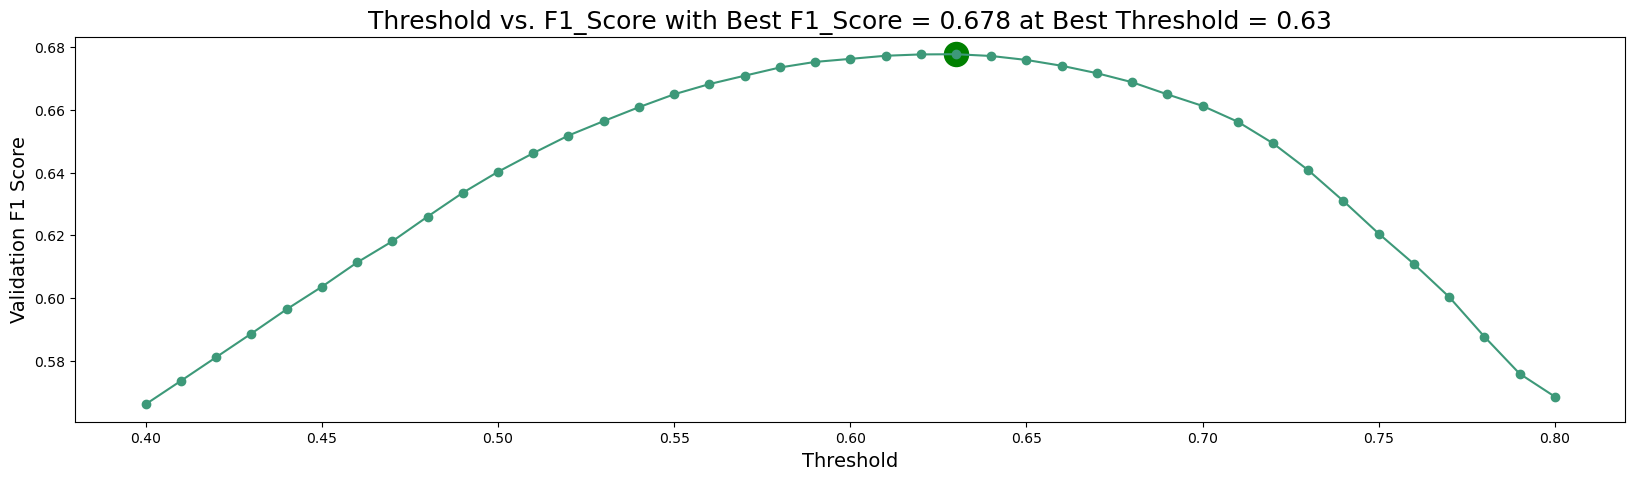

In [59]:
import matplotlib.pyplot as plt

gcolor = "#3d9979"
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color=gcolor)
plt.scatter([best_threshold], [best_score], color='green', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [60]:
%%time

print('When using optimal threshold...')
for k in range(18):
        
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k+1}: F1 =',m)
    
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print()
print('==> Overall F1 =',m)
print()

When using optimal threshold...
Q1: F1 = 0.6293108656019106
Q2: F1 = 0.49464879356568364
Q3: F1 = 0.4829379622111523
Q4: F1 = 0.6324578970065984
Q5: F1 = 0.5065834270852883
Q6: F1 = 0.6109099339605635
Q7: F1 = 0.4817562500321042
Q8: F1 = 0.542386878917178
Q9: F1 = 0.607140927996543
Q10: F1 = 0.33091012352690613
Q11: F1 = 0.585428708565125
Q12: F1 = 0.464792474337419
Q13: F1 = 0.42025490871512233
Q14: F1 = 0.6126218614377785
Q15: F1 = 0.4028140489440124
Q16: F1 = 0.4329700696445576
Q17: F1 = 0.4593821246728903
Q18: F1 = 0.48734796893017995

==> Overall F1 = 0.6778049498377591

CPU times: user 304 ms, sys: 1 ms, total: 305 ms
Wall time: 304 ms


In [61]:
# performance evaluatio metrics
print()
print("==> Overall Matrix = ")
print(classification_report(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int')))
print()


==> Overall Matrix = 
              precision    recall  f1-score   support

           0       0.53      0.57      0.55    124845
           1       0.82      0.79      0.80    299271

    accuracy                           0.73    424116
   macro avg       0.67      0.68      0.68    424116
weighted avg       0.73      0.73      0.73    424116




# Submission Jo Wilder

In [62]:
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [63]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for test, sample_submission in iter_test:
    sample_submission['question'] = [int(label.split('_')[1][1:]) for label in sample_submission['session_id']]
    grp = test.level_group.values[0]
    a,b = limits[grp]
    
    # ------------------- level 0-4 ---------------------------------
    if a == 1:
        FEATURES = FEATURES1
        test = (pl.from_pandas(test)
                  .drop(["fullscreen", "hq", "music"])
                  .with_columns(columns))
        test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
        test = test[FEATURES]
        test = test.fillna(0)
            

    # ------------------- level 5-12 ---------------------------------
    elif a == 4:
        FEATURES = FEATURES2
        test = (pl.from_pandas(test)
                  .drop(["fullscreen", "hq", "music"])
                  .with_columns(columns))
        test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
        test = test[FEATURES]
        test = test.fillna(0)

    # ------------------- level 13-22 ---------------------------------    
    elif a == 14:
        FEATURES = FEATURES3
        test = (pl.from_pandas(test)
                  .drop(["fullscreen", "hq", "music"])
                  .with_columns(columns))
        test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
        test = test[FEATURES]
        test = test.fillna(0)
    

    # INFER TEST DATA
    
    for t in range(a,b):
    #for t in range(1,2):
        clf = models[f'{grp}_{t}']
        
        p = clf.predict_proba(test.astype('float32'))[:,1]
        mask = sample_submission.question == t    
        sample_submission.loc[mask, 'correct'] = (p > best_threshold).astype('int') 
    env.predict(sample_submission[['session_id', 'correct']])

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [64]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head(10)

(54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090312143683264_q1,0
2,20090312331414616_q1,1
3,20090109393214576_q2,1
4,20090312143683264_q2,1
5,20090312331414616_q2,1
6,20090109393214576_q3,1
7,20090312143683264_q3,1
8,20090312331414616_q3,1
9,20090109393214576_q4,1
